In [450]:
import numpy as np
import torch
import tqdm
import torch.nn.utils
import matplotlib.pyplot as plt
import einops
from torch.nn import functional as F

from tqdm.notebook import trange, tqdm
#from model.py import Model, learning

In [508]:
class Model(torch.nn.Module):
    def __init__(self,n_features, n_hidden, S, n_instances=10, active=True):
        super().__init__()
        self.W = torch.nn.Parameter(torch.empty((n_instances, n_features, n_hidden)))
        torch.nn.init.xavier_normal_(self.W)
        self.b_final = torch.nn.Parameter(torch.zeros((n_instances, n_features)))
        self.active = active
        
        self.feature_probability = S
        self.n_instances = n_instances
        self.n_features = n_features
    
        
    def forward(self, features):

        hidden = torch.einsum("...if,ifh->...ih", features, self.W)

        out = torch.einsum("...ih,ifh->...if", hidden, self.W)

        out = out + self.b_final
        if self.active:
            out = F.relu(out)
        return out
    
    def generate_batch(self, n_batch):
        feat = torch.rand((n_batch, self.n_instances, self.n_features))
        batch = torch.where(
            torch.rand((n_batch, self.n_instances, self.n_features)) <= self.feature_probability,
            feat,
            torch.zeros(()),
        )
        return batch

In [510]:
def learning(x, importances, n, m, n_instances, S, epoch=10000, lr=0.001, batch_size=100):
    
    models = []
    for importance in tqdm(importances):

        model = Model(n, m, S,  n_instances)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        for epoch in range(epoch):


            optimizer.zero_grad()

            batch = model.generate_batch(batch_size)

            out = model(batch)

            error = (importance*(batch.abs() - out)**2)

            loss = einops.reduce(error, 'b i f -> i', 'mean').sum()

            loss.backward() 

            optimizer.step() 
        models.append(model)
    return models

In [532]:
def paint_(no_linear_models, n_istances, importances, S):
    colors = np.array([['darkorange' for x in range(n_istances)] for y in range(n_istances)])
    W_norm_all = np.zeros((n_istances, n_istances))

    polysemanticity_all = np.zeros((n_istances, n_istances))
    W_all = np.zeros((n_istances, n_istances))
    
    for i in range(len(no_linear_models)):
        W = no_linear_models[i].W.detach()
        
        W_norm = torch.linalg.norm(W, 2, dim=-1, keepdim=True)


        interference = torch.einsum('ifh,igh->ifg', W / (1e-5 + W_norm), W)
        interference[:, torch.arange(n), torch.arange(n)] = 0
        polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()
        
       
        
        W_norm_all[:,i] = W_norm[:,-1,-1]
        polysemanticity_all[:,i] = polysemanticity[:,-1] 
        W_all[:,i] = W[:,-1,-1]
        
        #print(W_norm, polysemanticity)



    fig,(plot_ax, bar_ax) = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
    
    x,y = np.meshgrid(
    np.linspace(0,1,n_istances),
    np.linspace(0,1,n_istances),
        
)

    
    plot_ax.imshow(np.dstack((polysemanticity_all, W_norm_all,  np.zeros_like(W_norm_all))),
        aspect = 'auto',
        #extent = (0.1,10,0.01,1),
    )
    
    plot_ax.set(xticks=[0, 19, 39], xticklabels=[0.1, 1, 10])
    plot_ax.set(yticks=[39, 19, 0], yticklabels=[0.01, 0.1, 1])
    
    
    bar_ax.imshow(np.dstack((x,y, np.zeros_like(x))),
        extent = (
            np.min(W_norm_all),np.max(W_norm_all),
            np.min(polysemanticity_all), np.max(polysemanticity_all),
        ),
        aspect = 'auto',
        origin = 'lower',
    )

    plot_ax.set_xlabel('Importance')
    plot_ax.set_ylabel('Sparcity')
    
    
    bar_ax.set_xlabel(r'$\sum_{j=1}^n(\hatW_i W_j)^2$')
    bar_ax.set_ylabel(r"$||W_i||$")
    
    plt.savefig("different_importance.pdf")
    
    return W_all, polysemanticity_all, W_norm_all

In [546]:
n = 2
m = 1
I = 0.7
num = 10000

epoch = 10000

n_instances = 40 # only even
#S = torch.tensor(([[1.0], [0.3], [0.1], [0.03], [0.01], [0.003], [0.001]]))


#S = torch.cat((torch.linspace(0.01, 0.1, n_instances // 2), torch.linspace(0.15, 1, n_instances // 2)))[:, None]

S = torch.cat((torch.linspace(1, 0.15, n_instances // 2), torch.linspace(0.1, 0.01, n_instances // 2)))[:, None]



X = np.random.rand(num, n)
importances = torch.cat((torch.linspace(0.1, 1,  n_instances // 2), torch.linspace(1.5, 10, n_instances // 2)))[:, None]
importances = torch.cat((torch.ones(importances.shape), importances), 1)

In [512]:
no_linear_models = learning(X, importances,  n, m, n_instances, S, epoch)

  0%|          | 0/40 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


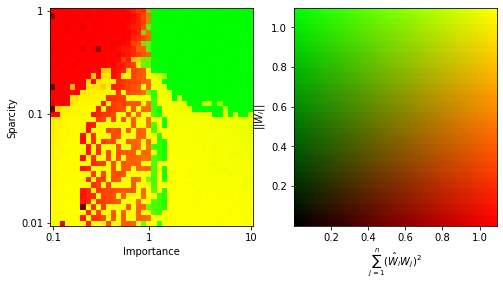

In [533]:
qwe = paint_(no_linear_models, n_instances, importances, S)